<a href="https://colab.research.google.com/github/krsna-thecoder/CNN---DEEP-LEARNING/blob/main/cnn%2Bquantum2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pennylane tensorflow scikit-learn


In [14]:
import pennylane as qml
from pennylane import numpy as pnp

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


Loading the dataset

In [15]:
CLASSES = [0, 2, 4, 6]
N_CLASSES = len(CLASSES)

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

train_idx = np.isin(y_train_raw, CLASSES)
test_idx  = np.isin(y_test_raw, CLASSES)

x_train = x_train_raw[train_idx] / 255.0
x_test  = x_test_raw[test_idx] / 255.0

y_train = y_train_raw[train_idx]
y_test  = y_test_raw[test_idx]


label_map = {c: i for i, c in enumerate(CLASSES)}
y_train = np.array([label_map[y] for y in y_train])
y_test  = np.array([label_map[y] for y in y_test])

x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)


applying cnn for convolution and pooling

In [16]:
def cnn_feature_extractor():
    inp = Input(shape=(28,28,1))

    x = Conv2D(32, (5,5), activation="relu", padding="same")(inp)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (5,5), activation="relu", padding="same")(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)


    features = Dense(6, activation="tanh")(x)

    return Model(inp, features)


pretraining the model

In [17]:
cnn = cnn_feature_extractor()
tmp_out = Dense(N_CLASSES, activation="softmax")(cnn.output)
tmp_model = Model(cnn.input, tmp_out)

tmp_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

tmp_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

cnn_model = Model(tmp_model.input, cnn.output)
cnn_model.trainable = False


Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5830 - loss: 1.0234 - val_accuracy: 0.7648 - val_loss: 0.6414
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7756 - loss: 0.6128 - val_accuracy: 0.7883 - val_loss: 0.5607
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8093 - loss: 0.5221 - val_accuracy: 0.8102 - val_loss: 0.4955
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8266 - loss: 0.4647 - val_accuracy: 0.8179 - val_loss: 0.4667
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8450 - loss: 0.4217 - val_accuracy: 0.8333 - val_loss: 0.4390


In [26]:
x_train_feat = cnn_model.predict(x_train, batch_size=128)
x_test_feat  = cnn_model.predict(x_test, batch_size=128)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


defining quantum classifier

In [27]:
N_QUBITS = 6
N_LAYERS = 2

dev = qml.device("default.qubit", wires=N_QUBITS)


In [28]:
@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def quantum_layer(weights, x):


    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)


    for l in range(N_LAYERS):
        for i in range(N_QUBITS):
            qml.RY(weights[l, i, 0], wires=i)
            qml.RZ(weights[l, i, 1], wires=i)

        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i+1])

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


checking the circuit made

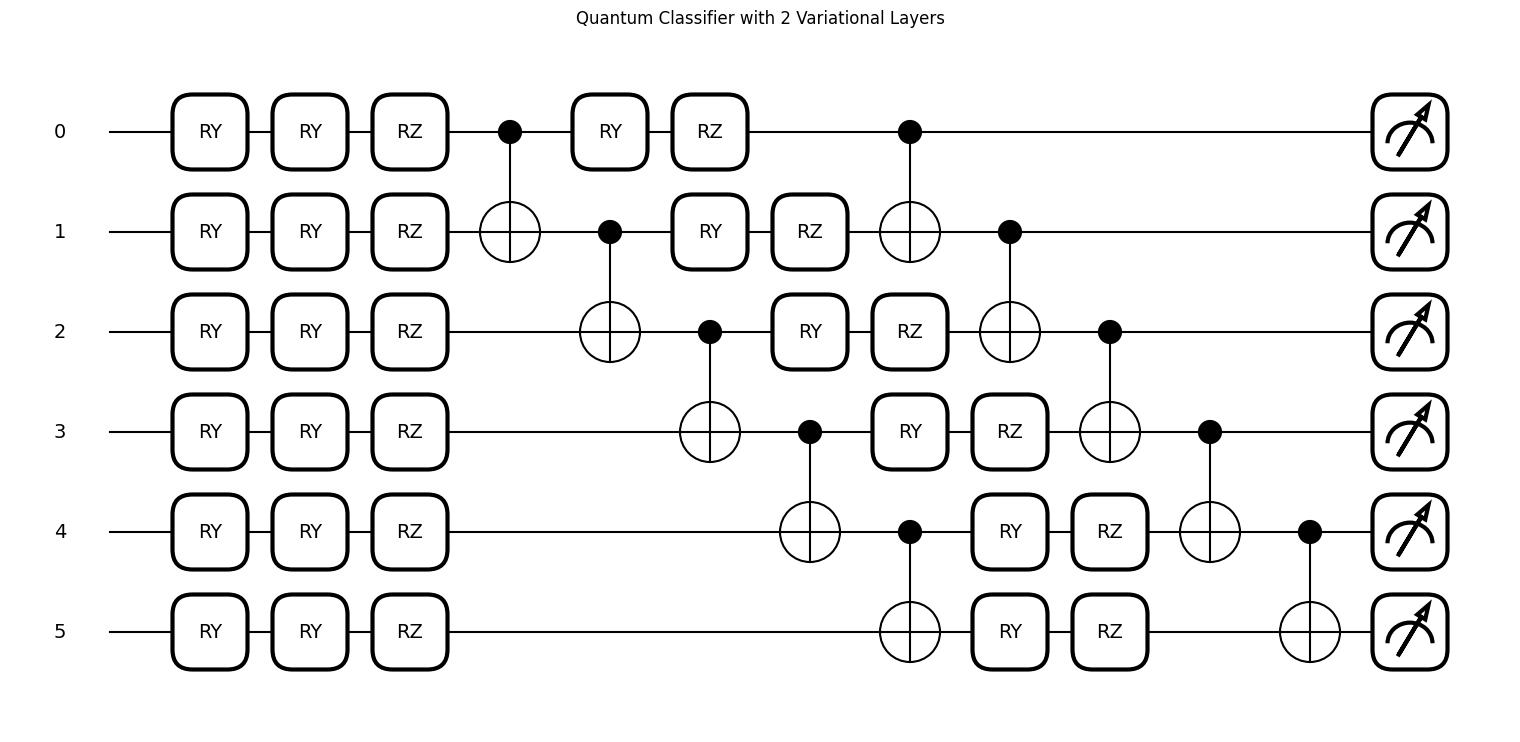

In [36]:
import matplotlib.pyplot as plt
from pennylane import numpy as pnp

# Dummy inputs
dummy_weights = pnp.random.normal(
    0, 0.1, (N_LAYERS, N_QUBITS, 2)
)
dummy_x = pnp.zeros(N_QUBITS)

# Draw full circuit (both layers automatically shown)
qml.draw_mpl(quantum_layer)(dummy_weights, dummy_x)

plt.title("Quantum Classifier with 2 Variational Layers")
plt.show()


applying softmax for getting probability

In [29]:
weights_q = pnp.random.normal(
    0, 0.1, (N_LAYERS, N_QUBITS, 2), requires_grad=True
)

W = pnp.random.normal(
    0, 0.2, (N_QUBITS, N_CLASSES), requires_grad=True
)

b = pnp.zeros(N_CLASSES, requires_grad=True)


In [33]:
def hybrid_forward(weights_q, W, b, x):
    q_out_list = quantum_layer(weights_q, x)
    q_out = pnp.array(q_out_list)
    return pnp.dot(q_out, W) + b

calculating cross entropy loss

In [31]:
def hybrid_loss(weights_q, W, b):
    loss = 0
    for i in range(200):
        logits = hybrid_forward(weights_q, W, b, x_train_feat[i])
        logits = logits - pnp.max(logits)
        probs = pnp.exp(logits) / pnp.sum(pnp.exp(logits))
        loss += -pnp.log(probs[y_train[i]])
    return loss / 200


training loop

In [34]:
opt = qml.AdamOptimizer(stepsize=0.02)
acc_history = []

for epoch in range(40):

    weights_q, W, b = opt.step(
        hybrid_loss,
        weights_q, W, b
    )

    preds = [
        np.argmax(hybrid_forward(weights_q, W, b, x_test_feat[i]))
        for i in range(len(x_test_feat))
    ]

    acc = np.mean(np.array(preds) == y_test)
    acc_history.append(acc)

    print(f"Epoch {epoch+1} | Hybrid Multi-Class Accuracy: {acc:.3f}")

Epoch 1 | Hybrid Multi-Class Accuracy: 0.256
Epoch 2 | Hybrid Multi-Class Accuracy: 0.267
Epoch 3 | Hybrid Multi-Class Accuracy: 0.304
Epoch 4 | Hybrid Multi-Class Accuracy: 0.321
Epoch 5 | Hybrid Multi-Class Accuracy: 0.344
Epoch 6 | Hybrid Multi-Class Accuracy: 0.363
Epoch 7 | Hybrid Multi-Class Accuracy: 0.370
Epoch 8 | Hybrid Multi-Class Accuracy: 0.392
Epoch 9 | Hybrid Multi-Class Accuracy: 0.454
Epoch 10 | Hybrid Multi-Class Accuracy: 0.510
Epoch 11 | Hybrid Multi-Class Accuracy: 0.536
Epoch 12 | Hybrid Multi-Class Accuracy: 0.583
Epoch 13 | Hybrid Multi-Class Accuracy: 0.627
Epoch 14 | Hybrid Multi-Class Accuracy: 0.656
Epoch 15 | Hybrid Multi-Class Accuracy: 0.661
Epoch 16 | Hybrid Multi-Class Accuracy: 0.665
Epoch 17 | Hybrid Multi-Class Accuracy: 0.666
Epoch 18 | Hybrid Multi-Class Accuracy: 0.667
Epoch 19 | Hybrid Multi-Class Accuracy: 0.668
Epoch 20 | Hybrid Multi-Class Accuracy: 0.670
Epoch 21 | Hybrid Multi-Class Accuracy: 0.672
Epoch 22 | Hybrid Multi-Class Accuracy: 0.6

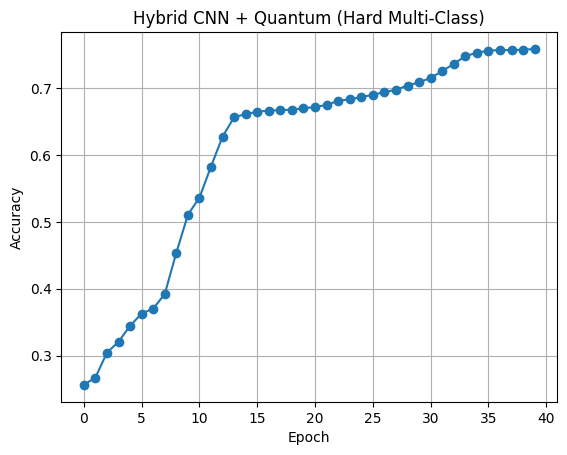

In [35]:
plt.plot(acc_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Hybrid CNN + Quantum (Hard Multi-Class)")
plt.grid(True)
plt.show()
